We are going to run the entire network on GRWL Tile and then use USGS width data for validation. This provides another avenue for validation. This mirrors the notebook for GRWL validation.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pyproj
import geopandas as gpd
from rasterio import features
from rasterio.warp import transform_bounds
import scipy.ndimage as nd
from orinoco import filter_binary_array_by_min_size, polygonize_array_to_shapefile, get_cropped_profile
from tqdm import tqdm
import scipy.ndimage as nd
from skimage import measure

# Specify the GRWL Directory

The data we have lies in the following directory structure:

+ Centerlines: `grwl_data/centerlines/<tile_name>.tif`
+ Mask: `grwl_data/masks/<tile_name>.tif`

In [2]:
tile_name = 'NH15'
grwl_data = Path('grwl_data')
grwl_data.exists()

True

# Create a Tile Directory for Output Proudcts

We use the tile name to create a directory for our products.

In [3]:
tile_dir = Path(f'out/{tile_name}')
tile_dir.mkdir(exist_ok=True, parents=True)

# Crop The Water Mask Data

Let's first inspect the data.

In [4]:
with rasterio.open(grwl_data/f'masks/{tile_name}.tif') as ds:
    water_mask = ds.read(1).astype(bool).astype(int)
    profile = ds.profile

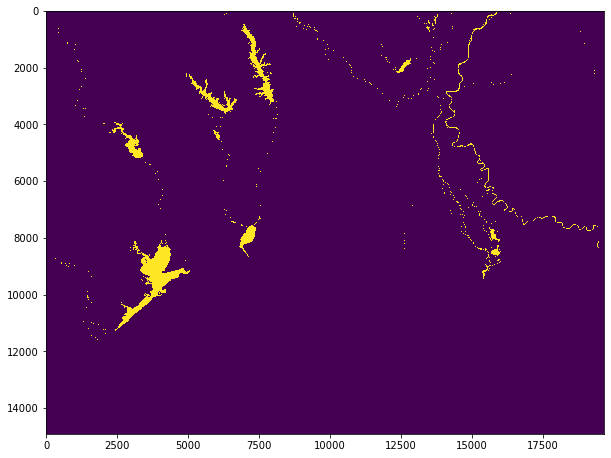

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(water_mask)

We manually find a window using numpy slices. We select a window that includes both the Sabine river, parts of the Mississippi, and of course, the Atchafalaya River Delta. This will provide us ample areas to validate the width product.

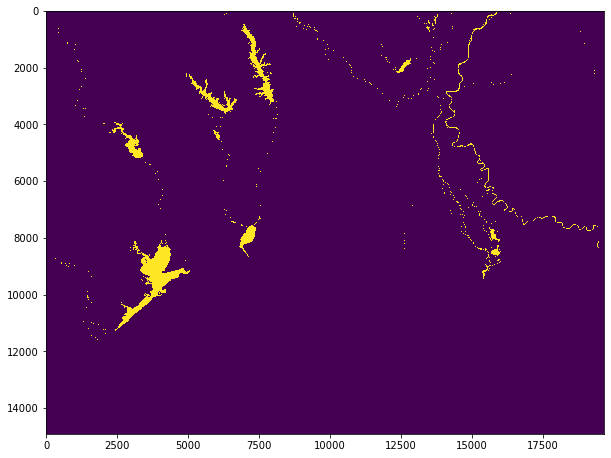

In [6]:
# sy = np.s_[:10_000]
# sx = np.s_[5_000:]
sy = np.s_[:]
sx = np.s_[:]

plt.figure(figsize=(10, 10))
plt.imshow(water_mask[sy, sx])

Having a satisfactory extent, we obtain the relevant geographic metadata and save the cropped area.

In [7]:
water_mask_c = water_mask[sy, sx]
profile_c = get_cropped_profile(profile, sx, sy)

with rasterio.open(tile_dir/f'water_mask_{tile_name}.tif', 'w', **profile_c) as ds:
    ds.write(water_mask_c.astype('uint8'), 1)

# Initialization Mask

We use this hydropolys [dataset](https://apps.gis.ucla.edu/geodata/dataset/world_water_bodies/resource/a6b40af0-84cb-40ce-b1c5-b024527a6943). This is a large dataset and we put it on an external hard drive.

Update your path accordingly.

In [8]:
water_body_shapefile = Path('/Volumes/BigData/river_data/hydropolys')
water_body_shapefile.exists()

True

We utilize rasterio's [`rasterize`](https://rasterio.readthedocs.io/en/latest/topics/features.html#burning-shapes-into-a-raster) to transalte the ocean geometry from the dataset above.

In [9]:
def translate_one(geometry, profile):
    shapes = [(geometry, 1)]
    out_arr = np.zeros((profile['height'], profile['width']))
    burned = features.rasterize(shapes=shapes,
                                out=out_arr,
                                transform=profile['transform'],
                                all_touched=True)
    return burned

We obtain the bounds of our dataset and use this to read a subset of the large shapefile consisting of global waterbodies. Then we translate the shapefile into a raster.

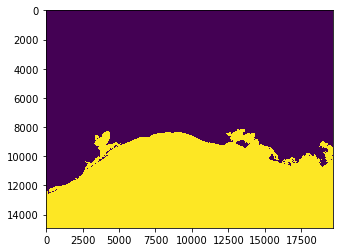

In [18]:
with rasterio.open(tile_dir/f'water_mask_{tile_name}.tif') as ds:
    bounds = ds.bounds
    crs = str(ds.crs).lower()
    profile = ds.profile
bounds_4326 = transform_bounds(crs, 'epsg:4326', *bounds)
oceanline_df = gpd.read_file(water_body_shapefile, bbox=bounds_4326).to_crs({'init':crs})
oceanline_df = oceanline_df[oceanline_df['TYPE'] == 'Ocean or Sea'].copy()
ocean_geometry = oceanline_df.geometry.unary_union.buffer(1e-9)
ocean_mask = translate_one(ocean_geometry, profile)
# Make sure all the rivers are connected to the ocean
# Approximately 300 meter buffer
ocean_mask = nd.binary_dilation(ocean_mask, iterations=10)
plt.imshow(ocean_mask)

We save the raster to our product directory.

In [19]:
with rasterio.open(tile_dir/f'ocean_mask_{tile_name}.tif', 'w', **profile) as ds:
    ds.write(ocean_mask.astype('uint8'), 1)

# Save Channel Mask as Shapefile

This will be useful for intersecting USGS stations. We will provide a buffer of 60 meters to ensure the water masks get all available stations.

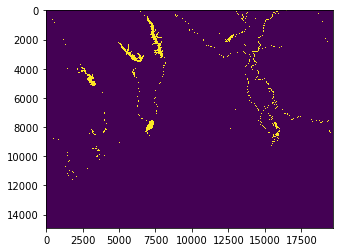

In [20]:
channel_mask = water_mask_c.astype(bool) & ~ocean_mask.astype(bool)
channel_mask = nd.binary_dilation(channel_mask, iterations=2).astype(bool)
plt.imshow(channel_mask)

In [21]:
polygonize_array_to_shapefile(channel_mask.astype(np.uint8), 
                              profile, tile_dir/f'channel_mask_{tile_name}', 
                              mask=~channel_mask)